# Задание 2

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/home/andor/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/andor/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/home/andor/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/home/andor/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/home/andor/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/home/andor/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: cannot open shared object file: No s

In [2]:
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.091135,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093777,73449600


Аргумент history_size — это размер последнего временного интервала, target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Изменение размера данных с (history_size,) на (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

В обеих частях ноутбука первые 300 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). В этом случае объём обучающих данных составляет примерно 2100 дней.

In [4]:
TRAIN_SPLIT = 5000

Для обеспечения воспроизводимости результатов устанавливается функция seed.

In [5]:
tf.random.set_seed(13)

## Часть 1. Прогнозирование на основе одномерного временного ряда

Для начала извлечем только цену акции на момент закрытия торгов из набора данных.

In [6]:
uni_data = df['Close']
uni_data.index = df['Date']
uni_data.head()

Date
1980-12-12    0.128348
1980-12-15    0.121652
1980-12-16    0.112723
1980-12-17    0.115513
1980-12-18    0.118862
Name: Close, dtype: float64

И посмотрим, как эти данные изменяются во времени.

array([<AxesSubplot: xlabel='Date'>], dtype=object)

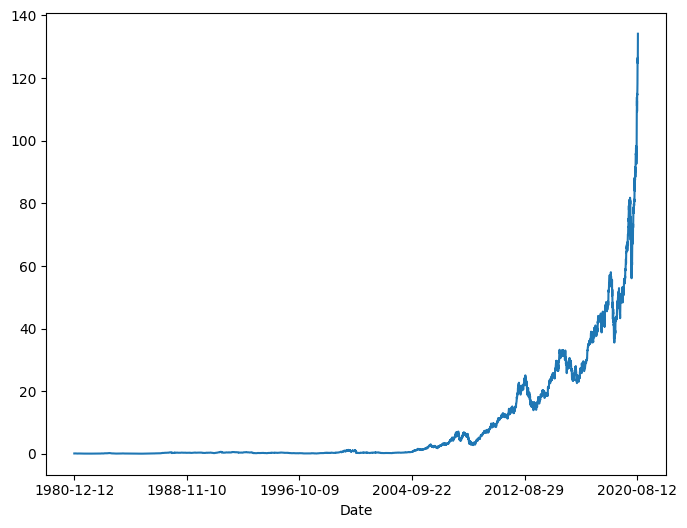

In [7]:
uni_data.plot(subplots=True)

In [8]:
uni_data = uni_data.values

Выполним стандартизацию данных.

In [9]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Далее подготовим данные для модели с одномерным входом. На вход в модель будут подаваться последние 20 зарегистрированных наблюдений за температурой, и модель необходимо обучить прогнозировать температуру на следующем шаге по времени.

In [10]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Результаты применения функции univariate_data.

In [11]:
print ('Интервал цены на момент закрытия для наблюдений')
print (x_train_uni[0])
print ('\n Целевая цена для прогнозирования')
print (y_train_uni[0])

Интервал цены на момент закрытия для наблюдений
[[-0.88110504]
 [-0.91453523]
 [-0.95911382]
 [-0.94518457]
 [-0.92846448]
 [-0.89224844]
 [-0.86160409]
 [-0.8337406 ]
 [-0.79752456]
 [-0.73065918]
 [-0.71951578]
 [-0.73901672]
 [-0.76130352]
 [-0.75294597]
 [-0.76966107]
 [-0.80309626]
 [-0.8337406 ]
 [-0.84766985]
 [-0.81145381]
 [-0.81702551]]

 Целевая цена для прогнозирования
-0.8420981519570218


Теперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. Передаваемая в ИНС (искуственная нейронная сеть) информация на графике выделена синим цветом, а красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.


In [12]:
def create_time_steps(length):
  return list(range(-length, 0))

In [13]:
def show_plot(plot_data, delta, title):
  labels = ['История', 'Истинное будущее значение', 'Прогноз модели']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Временной интервал')
  return plt

<module 'matplotlib.pyplot' from '/home/andor/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

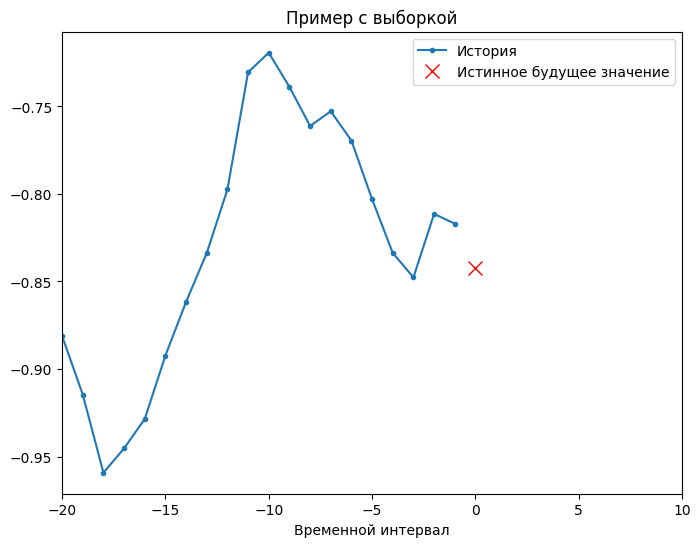

In [14]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Пример с выборкой')

#### Базовое решение (без привлечения машинного обучения)

Прежде чем приступить к обучению модели, установим простое базовое решение (baseline). Оно заключается в следующем: для заданного входного вектора метод базового решения «просматривает» всю историю и прогнозирует следующее значение как среднее из последних 20 наблюдений.

In [15]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/andor/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

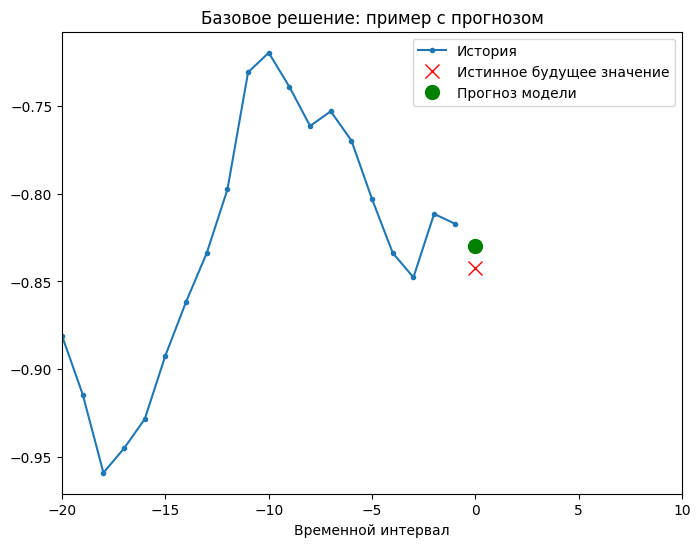

In [16]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Базовое решение: пример с прогнозом')

Посмотрим, сможем ли мы превзойти результат «усреднения», использую рекуррентную нейронную сеть.

#### Рекуррентная нейронная сеть



Рекуррентная нейронная сеть (РНС) — это тип ИНС, который хорошо подходит для решения задач, связанных с временными рядами. РНС шаг за шагом обрабатывает временную последовательность данных, перебирая её элементы и сохраняя внутреннее состояние, полученное при обработке предыдущих элементов.  В данном ноутбуке будет использоваться специализированный слой РНС, который называется «Долгая краткосрочная память» (англ. Long Short-Term Memory, LSTM).

Далее с помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.

*Дополнение:*

*Подробнее про методы shuffle, batch и cache на странице [tensorflow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):*

In [17]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Следующая визуализация должна помочь понять, как выглядят данные после пакетной обработки.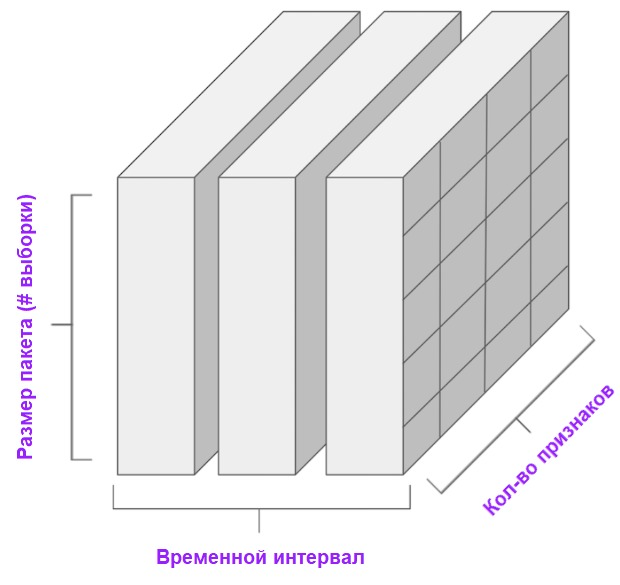

Видно, что LSTM требует определённой формы ввода данных, которые ему предоставляются.

In [18]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Проверим выход модели.

In [19]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 1s 10ms/step
(256, 1)


*Дополнение:*

*В общем плане РНС работают с последовательностями (sequences). Это означает, что подаваемые на вход модели данные должны иметь следующую форму:*

*[наблюдения, временной интервал, кол-во признаков]*
*Форма обучающих данных для модели с одномерным входом имеет следующий вид:*

*print(x_train_uni.shape)*
*(299980, 20, 1)*

Далее займёмся обучением модели. Из-за большого размера набора данных и в целях экономии времени каждая эпоха будет проходить только 200 шагов (steps_per_epoch=200) вместо полных данных обучения, как это обычно делается.

In [20]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 11s 27ms/step - loss: 0.3438 - val_loss: 71.0626
Epoch 2/10
200/200 [==============================] - 4s 19ms/step - loss: 0.1149 - val_loss: 70.6784
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0710 - val_loss: 70.5376
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0539 - val_loss: 70.2677
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0481 - val_loss: 69.8504
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0446 - val_loss: 69.4656
Epoch 7/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0424 - val_loss: 69.3195
Epoch 8/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0408 - val_loss: 69.1815
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0398 - val_loss: 68.9599
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.038

#### Прогнозирование с использованием простой модели LSTM

После выполнения подготовки простой LSTM-модели, выполним несколько прогнозов.

8/8 [==============================] - 0s 12ms/step


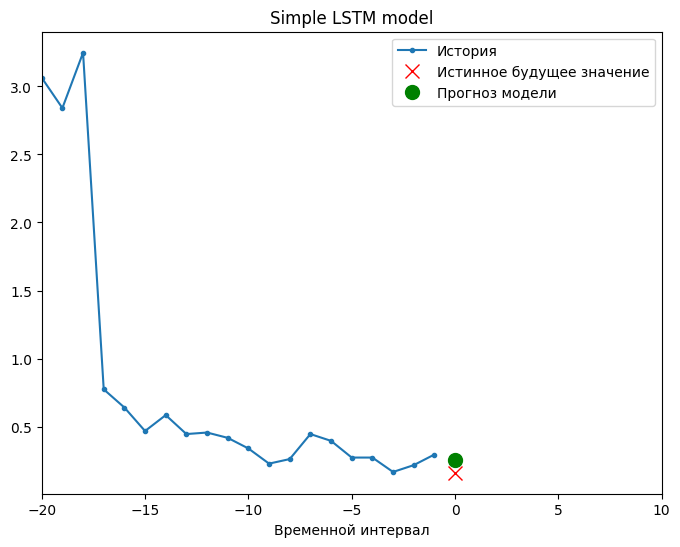

8/8 [==============================] - 0s 3ms/step


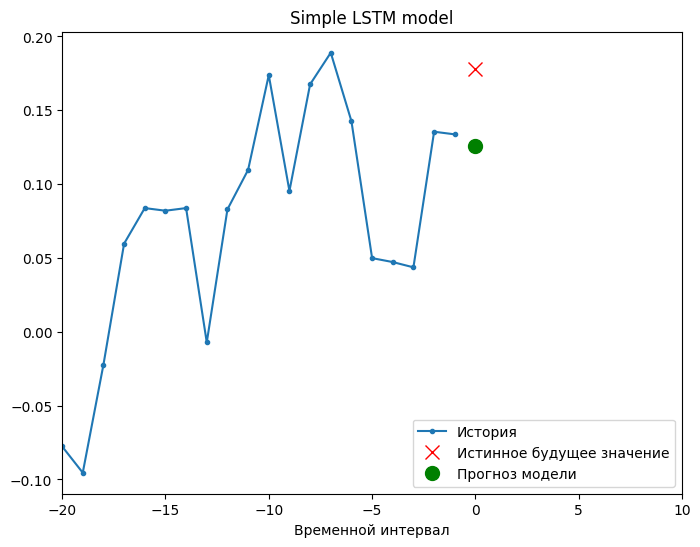

8/8 [==============================] - 0s 4ms/step


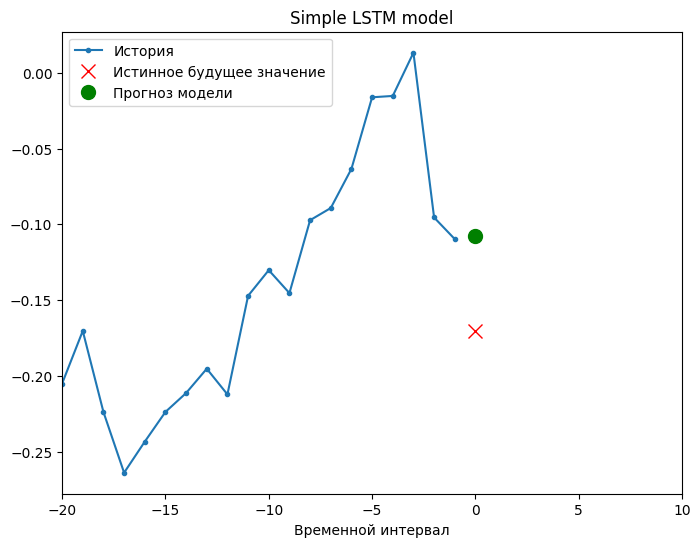

In [21]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

Выглядит лучше, чем базовый уровень.

Теперь, когда мы ознакомились с основами, давайте перейдем ко второй части, в которой описывается работа с многомерным временным рядом.

## Часть 2: Прогнозирование на основе многомерного временного ряда

Как было сказано, исходный набор данных содержит 14 различных метеорологических показателей. Для простоты и удобства во второй части рассматриваются только три из них — температура воздуха, атмосферное давление и плотность воздуха.

Чтобы использовать больше признаков, их названия нужно добавить в список feature_considered.

In [22]:
features_considered = ['Open', 'High', 'Low']

In [23]:
features = df[features_considered]
features.index = df['Date']
features.head()

,Open,High,Low
Date,,,
1980-12-12,0.128348,0.128906,0.128348
1980-12-15,0.122210,0.122210,0.121652
1980-12-16,0.113281,0.113281,0.112723
1980-12-17,0.115513,0.116071,0.115513
1980-12-18,0.118862,0.119420,0.118862


Посмотрим, как эти показатели изменяются во времени.

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>], dtype=object)

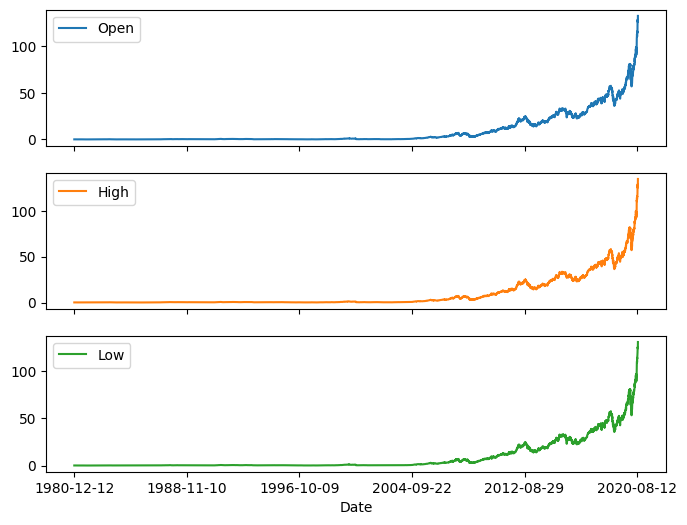

In [24]:
features.plot(subplots=True)

Как и ранее, первым шагом будет выполнение стандартизации набора данных с вычислением среднего значения и стандартного отклонения обучающих данных.

In [25]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

#### Точечное прогнозирование

В данном случае модель обучается прогнозированию одного значения в будущем на основе некой имеющейся истории.
Приведенная ниже функция выполняет ту же задачу организации временных интервалов лишь с тем отличием, что здесь она отбирает последние наблюдения на основе заданного размера шага.

In [26]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

В данном руководстве ИНС оперирует данными за последние пять (5) дней, то есть 720 наблюдениями (6х24х5). Допустим, что отбор данных проводится не каждые 10 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. Следовательно, историю последних пяти дней составляют 120 наблюдений (720/6). Для модели, выполняющей точечное прогнозирование, целью является значение температуры через 12 часов в будущем. В этом случае целевой вектор будет составлять температура после 72 (12х6) наблюдений

In [27]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Проверим временной интервал.

In [28]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [29]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [30]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки.

In [31]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 1s 9ms/step
(256, 1)


In [32]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 77s 377ms/step - loss: 0.3967 - val_loss: 94.8482
Epoch 2/10
200/200 [==============================] - 81s 402ms/step - loss: 0.2847 - val_loss: 94.3576
Epoch 3/10
200/200 [==============================] - 60s 301ms/step - loss: 0.2149 - val_loss: 94.3163
Epoch 4/10
200/200 [==============================] - 47s 234ms/step - loss: 0.1676 - val_loss: 94.6147
Epoch 5/10
200/200 [==============================] - 62s 310ms/step - loss: 0.1422 - val_loss: 94.6341
Epoch 6/10
200/200 [==============================] - 68s 337ms/step - loss: 0.1267 - val_loss: 94.5623
Epoch 7/10
200/200 [==============================] - 51s 254ms/step - loss: 0.1164 - val_loss: 94.6028
Epoch 8/10
200/200 [==============================] - 49s 243ms/step - loss: 0.1062 - val_loss: 94.7007
Epoch 9/10
200/200 [==============================] - 63s 314ms/step - loss: 0.1001 - val_loss: 94.7089
Epoch 10/10
200/200 [==============================] - 65s 323ms

In [33]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
  plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
  plt.title(title)
  plt.legend()

  plt.show()

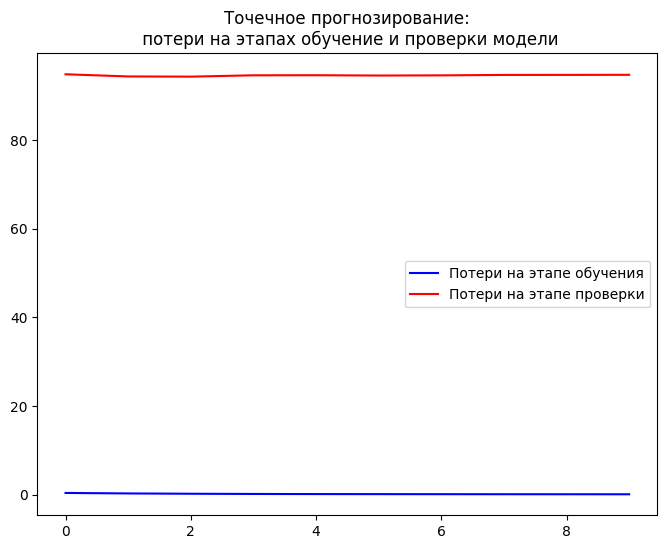

In [34]:
plot_train_history(single_step_history,
                   'Точечное прогнозирование:\n потери на этапах обучение и проверки модели')

#### Выполнение точечного прогноза

Теперь, когда модель обучена, выполним несколько пробных прогнозов. На вход модели подаётся история наблюдений 3-х признаков за последние пять дней, отобранных каждый час (временной интервал = 120). Так как наша цель заключается в прогнозе только температуры, то синим цветом на графике отображены прошлые значения температуры (история). Прогноз выполнен на полдня в будущее (отсюда и разрыв между историей и спрогнозированным значением).

8/8 [==============================] - 1s 68ms/step


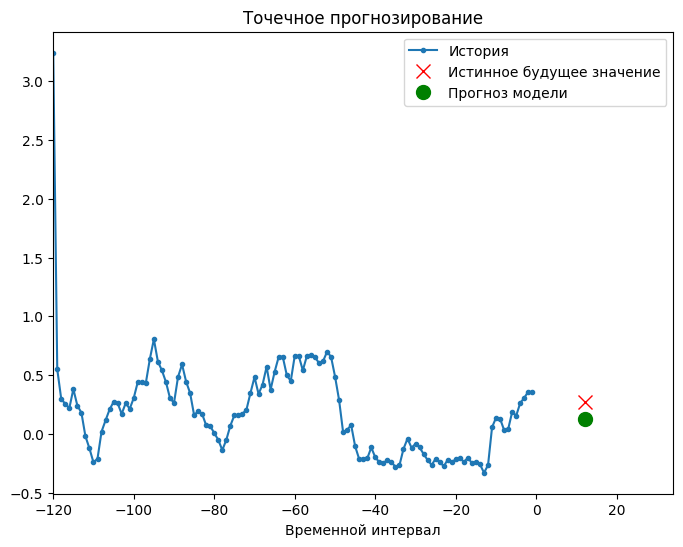

8/8 [==============================] - 0s 32ms/step


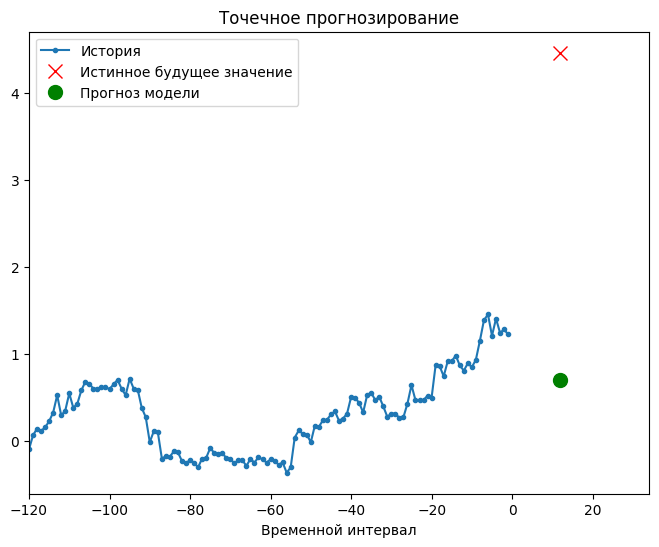

8/8 [==============================] - 0s 23ms/step


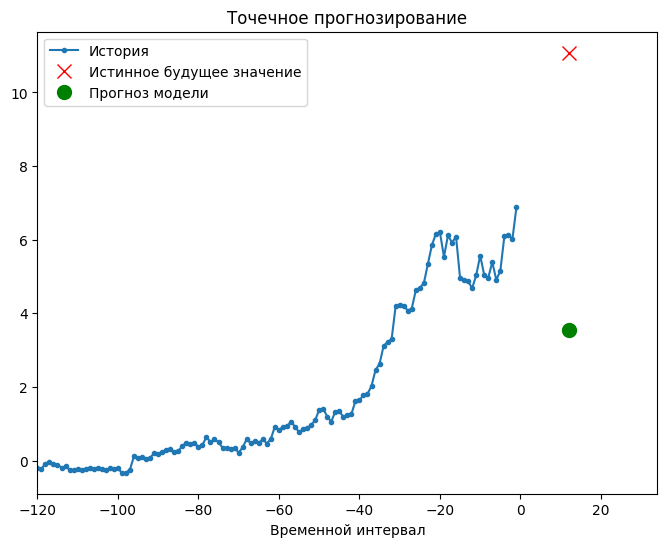

In [35]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Точечное прогнозирование')
  plot.show()

#### Интервальное прогнозирование

В этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. Таким образом, в отличие модели, прогнозирующей только на одно значение в будущее, данная модель прогнозирует последовательность значений в будущем.

Допустим, как и в случае с моделью, выполняющей точечное прогнозирование, для модели, выполняющей интервальное прогнозирование, обучающими данными являются почасовые замеры последних пяти дней (720/6). Однако в данном случае модель необходимо обучить прогнозировать температуру на следующие 12 часов. Поскольку наблюдения регистрируются каждые 10 минут, выход (output) модели должен состоять из 72 прогнозов. Для выполнения этой задачи необходимо подготовить набор данных заново, но с другим целевым интервалом.

In [36]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Проверим выборку

In [37]:
print ('Временной интервал для наблюдений : {}'.format(x_train_multi[0].shape))
print ('\n Целевая температура для прогнозирования : {}'.format(y_train_multi[0].shape))

Временной интервал для наблюдений : (120, 3)

 Целевая температура для прогнозирования : (72,)


In [38]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Подготовим визуализацию

In [39]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='История')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='Истинное будущее значение')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Прогноз модели')
  plt.legend(loc='upper left')
  plt.show()

На этом и последующих аналогичных графиках история и будущие данные ежечасные

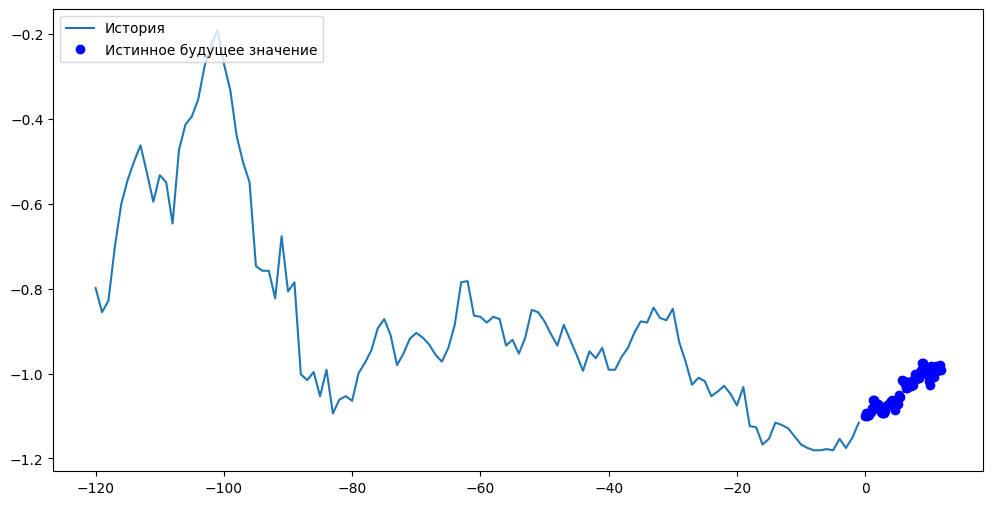

In [40]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Так как эта задача немного сложнее, чем предыдущая, то модель будет состоять из двух слоёв LSTM. Наконец, поскольку выполняется 72 прогноза, выход слой насчитывает 72 нейрона.

In [41]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки

In [42]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 2s 45ms/step
(256, 72)


In [43]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 149s 718ms/step - loss: 0.3984 - val_loss: 89.4907
Epoch 2/10
200/200 [==============================] - 145s 724ms/step - loss: 0.2645 - val_loss: 88.1351
Epoch 3/10
200/200 [==============================] - 170s 848ms/step - loss: 0.2225 - val_loss: 90.9114
Epoch 4/10
200/200 [==============================] - 149s 745ms/step - loss: 0.1761 - val_loss: 90.8763
Epoch 5/10
200/200 [==============================] - 178s 887ms/step - loss: 0.1557 - val_loss: 91.3899
Epoch 6/10
200/200 [==============================] - 139s 695ms/step - loss: 0.1441 - val_loss: 92.1659
Epoch 7/10
200/200 [==============================] - 185s 922ms/step - loss: 0.1339 - val_loss: 92.3079
Epoch 8/10
200/200 [==============================] - 269s 1s/step - loss: 0.1256 - val_loss: 92.2610
Epoch 9/10
200/200 [==============================] - 241s 1s/step - loss: 0.1187 - val_loss: 92.4305
Epoch 10/10
200/200 [==============================] - 164s 8

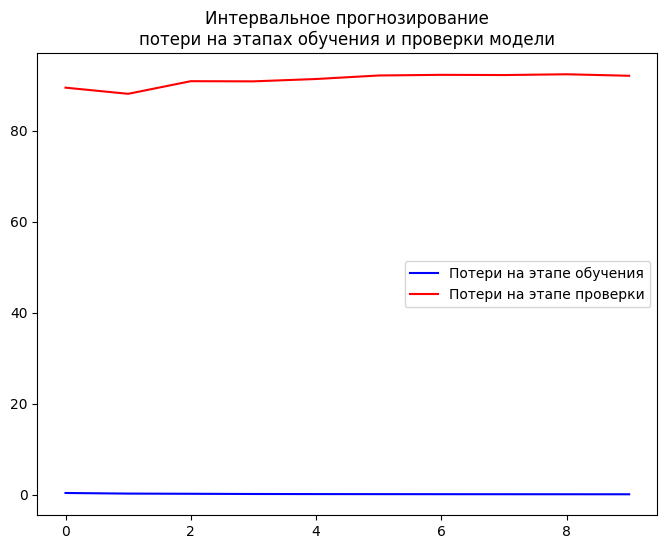

In [44]:
plot_train_history(multi_step_history, 'Интервальное прогнозирование\nпотери на этапах обучения и проверки модели')

#### Выполнение интервального прогноза

Итак, давайте выясним, насколько успешно обученная ИНС справляется с прогнозами будущих значений температуры.

8/8 [==============================] - 2s 134ms/step


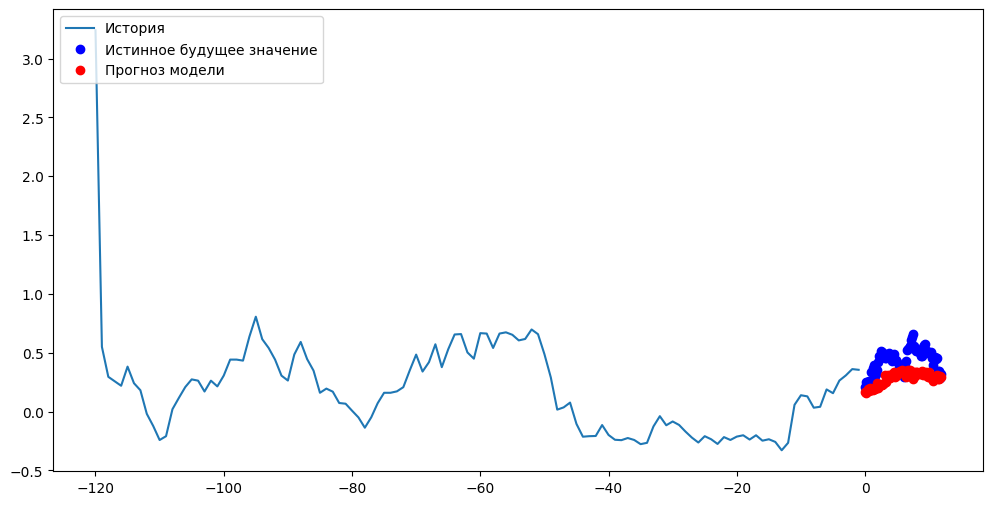

8/8 [==============================] - 1s 62ms/step


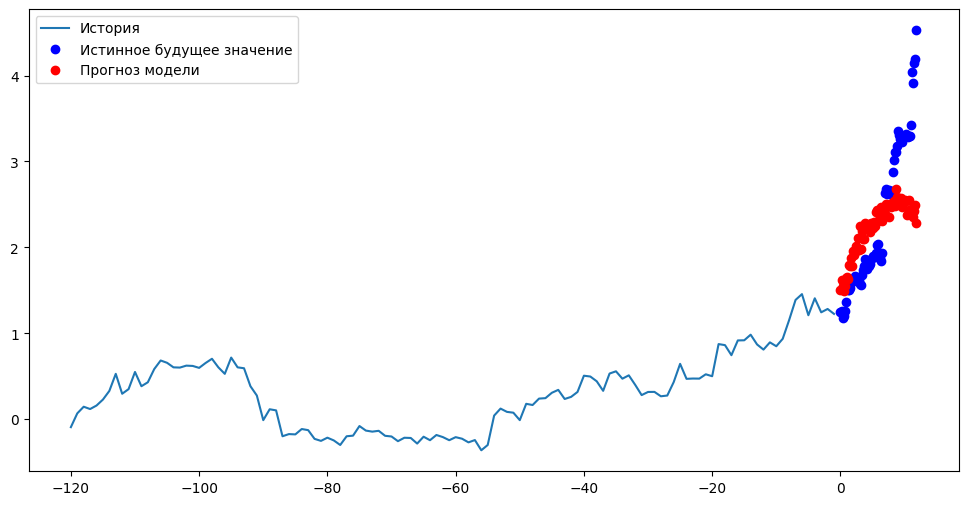

8/8 [==============================] - 1s 63ms/step


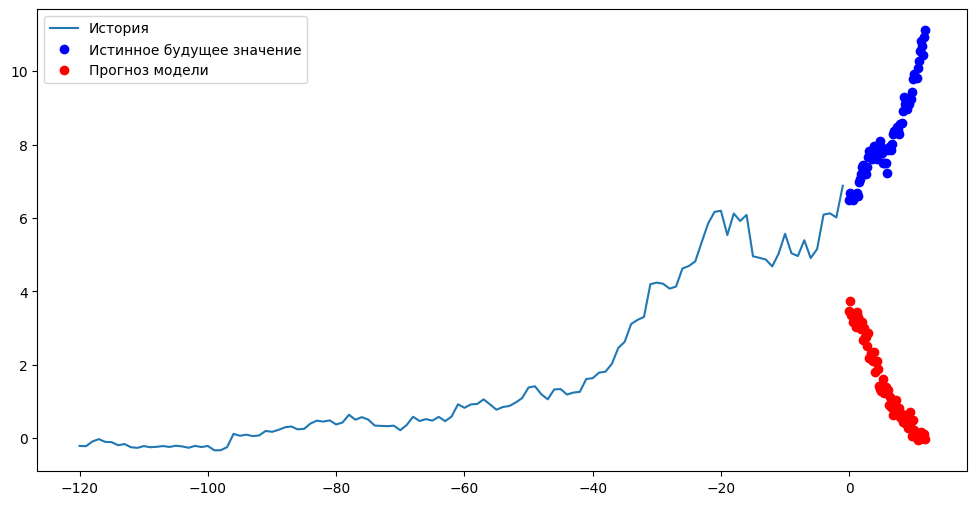

In [45]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])